# EDA and Signal Pre-processing

In [27]:
from file_io import * 
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

In [28]:
# relabeling config
LEN_PRE = 15
LEN_POS = 60
SEC_GAP = 0

In [29]:
train_path = '../tusz_1_5_2/edf/train'
tcp_type = '01_tcp_ar'
patient_group = '004'
patient = '00000492'
session = 's003_2003_07_18'
token = '00000492_s003_t001'

In [30]:
# tokens_bucket = []  # list of statistics to explore in between tokens.


# def preprocess(edf_path_no_extension:str):
#     f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))
#     # sort channel label
#     s = sort_channel(s, l, STD_CHANNEL_01_AR)
#     f = int(np.mean(f))
#     intvs, labls = load_tse_bi(tf)
#     intvs, labls = relabel_tse_bi(intvs=intvs, labels=labls, len_pre=LEN_PRE, len_post=LEN_POS, sec_gap=SEC_GAP)
#     ds, lbl = signal_to_dataset(sig=s, fsamp=f, intvs=intvs, labels=labls)
#     return ds, lbl

f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))
#TODO: 1 should be np.array
s = np.array(s)
s.shape

df0 = pd.DataFrame(s.transpose(), columns=["ch"+str(i) for i in range(0, 22)])

### DC Offset

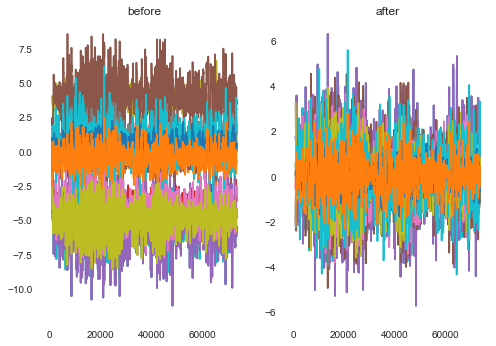

In [38]:
def remove_dc_offset(df:pd.DataFrame):
    return(df.apply(lambda x: x - np.mean(x)))

df = df0.apply(lambda x: x - np.mean(x))

import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

df0\
.iloc[:,:]\
.rolling(1000)\
.mean()\
.plot(title='before', legend=False, ax=axes[0])

df.rolling(1000).mean().plot(title='after', legend=False, ax=axes[1])

### High + Low Filter

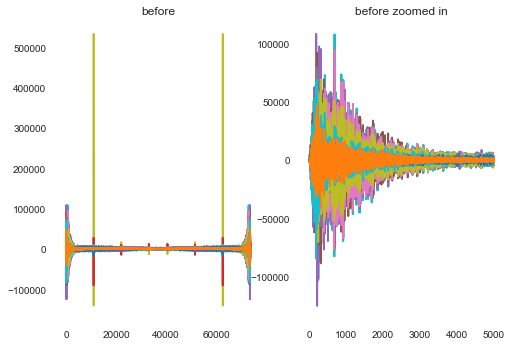

In [37]:
#FFT
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

import scipy.fft as fft
df_fft = df.apply(lambda x: np.real(fft.fft(x.to_numpy())))

df_fft.plot(title='before', legend=False, ax=axes[0])
df_fft.loc[0:5000, :].plot(title='before zoomed in', legend=False, ax=axes[1])

# low pass needed

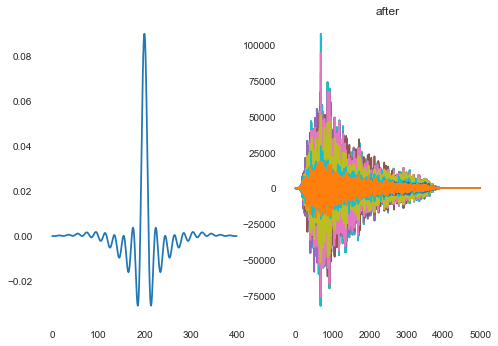

In [36]:
# LOW PASS FILTER
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

from scipy import signal
filter = signal.firwin(400, [0.01, 0.1], pass_zero=False)
axes[0].plot(filter)
plt.title('Firwin(400)')

df_fft = df.apply(lambda x: np.real(fft.fft(signal.convolve(x.to_numpy(), filter, mode='same'))))
# df_fft.plot()
df_fft.loc[0:5000, :].plot(title = 'after', legend=False, ax=axes[1])

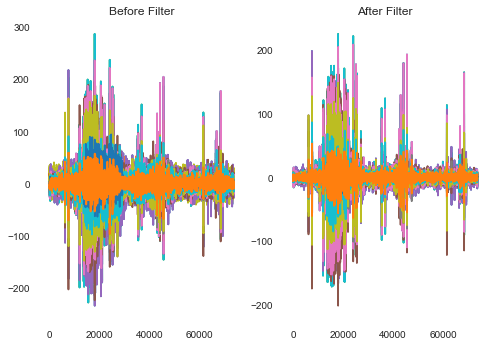

In [35]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

df.plot(legend=False,title='Before Filter', ax=axes[0])
df1 = df.apply(lambda x: np.real(signal.convolve(x.to_numpy(), filter, mode='same')))
df1.plot(legend=False, title='After Filter', ax=axes[1])

## Channel Selection
statistics of each channels and their correlation

In [10]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df1, minimal=True, explorative=True)

profile.to_notebook_iframe()

##### Summary statistics

In [11]:
channels_stats = df1.describe()\
    .append(df.skew().rename('skew'))\
    .append(df.kurtosis().rename('kurt'))
channels_stats

,ch0,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,...,ch12,ch13,ch14,ch15,ch16,ch17,ch18,ch19,ch20,ch21
count,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,...,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000,73600.000000
mean,-0.003038,-0.003690,-0.002607,-0.000926,0.001390,-0.002305,-0.000588,-0.002195,0.000384,-0.002607,...,-0.000600,-0.000588,-0.003038,-0.000231,-0.002396,-0.002621,0.001390,-0.002466,-0.000600,-0.001403
std,19.336414,5.400221,21.214579,4.761802,13.972688,4.702563,6.762864,3.392971,6.813558,21.214579,...,3.849370,6.762864,19.336414,18.455215,19.029072,8.292521,13.972688,7.688840,3.849370,6.134662
min,-166.662589,-63.202980,-171.671732,-46.810644,-112.961470,-56.532855,-61.496504,-30.109413,-66.982838,-171.671732,...,-37.885276,-61.496504,-166.662589,-201.683039,-152.686262,-101.108268,-112.961470,-85.081246,-37.885276,-63.870188
25%,-5.201554,-2.175946,-5.066717,-2.414856,-3.456604,-1.947273,-2.488567,-1.809274,-2.726626,-5.066717,...,-1.285083,-2.488567,-5.201554,-4.597967,-4.658690,-2.923476,-3.456604,-2.932301,-1.285083,-2.409849
50%,0.095351,-0.092838,-0.111110,-0.125807,-0.047214,-0.067252,-0.030566,-0.111355,0.078644,-0.111110,...,-0.013181,-0.030566,0.095351,-0.134149,-0.183119,-0.147291,-0.047214,-0.095009,-0.013181,-0.112083
75%,5.830416,1.950095,5.196013,2.279538,3.658140,1.831847,2.405890,1.624128,2.857697,5.196013,...,1.235951,2.405890,5.830416,4.420412,4.375084,2.535266,3.658140,2.737408,1.235951,2.158642
max,198.619667,50.511891,225.412949,51.249697,148.779340,53.041700,70.773298,30.719473,68.715687,225.412949,...,30.022962,70.773298,198.619667,171.943942,208.787499,75.212670,148.779340,86.497956,30.022962,53.146212
skew,-1.272164,0.361896,-0.697985,0.268121,-0.826665,0.050514,-0.178453,0.220705,0.018874,-0.697985,...,1.381044,-0.178453,-1.272164,1.209902,-0.137331,0.740543,-0.826665,-0.031675,1.381044,0.533421
kurt,9.042575,4.398408,13.959570,1.191823,10.616490,3.171911,5.592309,1.070509,0.303862,13.959570,...,15.566464,5.592309,9.042575,13.417880,14.630177,6.328494,10.616490,2.653002,15.566464,5.062587


##### Correlation

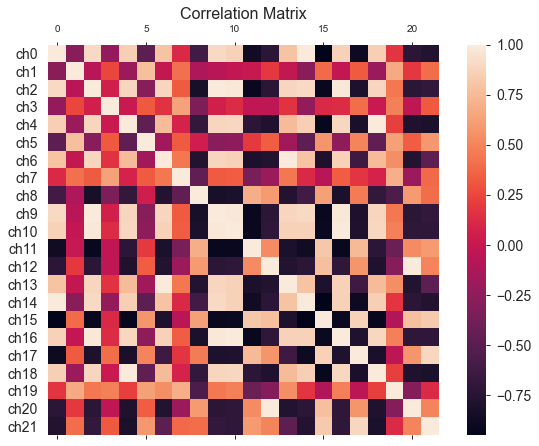

In [12]:
def plot_corrmat(corrmat, columns):
    f = plt.figure(figsize=(10, 7))
    plt.matshow(corrmat, fignum=f.number)
#     plt.xticks(range(len(columns)), columns, fontsize=14, rotation=45)
    plt.yticks(range(len(columns)), columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16);
    
channels_corrmat = df1.corr()
plot_corrmat(channels_corrmat, df1.columns)

(array([[ 4.,  3.,  1.,  2.,  0.,  2.,  0.,  0.,  2.,  8.],
        [ 0.,  0.,  0.,  4.,  8.,  2.,  4.,  1.,  2.,  1.],
        [ 4.,  3.,  0.,  1.,  1.,  1.,  1.,  1.,  0., 10.],
        [ 0.,  0.,  0.,  3.,  5.,  7.,  4.,  1.,  1.,  1.],
        [ 5.,  2.,  1.,  1.,  1.,  2.,  0.,  0.,  2.,  8.],
        [ 0.,  0.,  4.,  4.,  2.,  2.,  4.,  3.,  2.,  1.],
        [ 5.,  1.,  1.,  0.,  2.,  1.,  0.,  2.,  4.,  6.],
        [ 0.,  0.,  1.,  3.,  1.,  5.,  6.,  3.,  2.,  1.],
        [ 6.,  4.,  2.,  1.,  1.,  1.,  1.,  3.,  2.,  1.],
        [ 4.,  3.,  0.,  1.,  1.,  1.,  1.,  1.,  0., 10.],
        [ 4.,  3.,  0.,  1.,  1.,  1.,  1.,  1.,  0., 10.],
        [ 8.,  2.,  1.,  1.,  2.,  1.,  0.,  3.,  2.,  2.],
        [ 4.,  6.,  0.,  2.,  1.,  1.,  1.,  4.,  1.,  2.],
        [ 5.,  1.,  1.,  0.,  2.,  1.,  0.,  2.,  4.,  6.],
        [ 4.,  3.,  1.,  2.,  0.,  2.,  0.,  0.,  2.,  8.],
        [10.,  0.,  0.,  0.,  2.,  1.,  1.,  1.,  3.,  4.],
        [ 4.,  3.,  0.,  1.,  1.,  1.,  

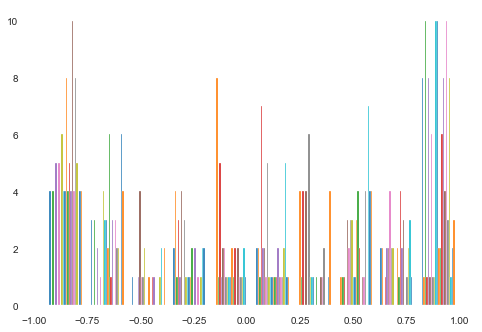

In [13]:
plt.hist(channels_corrmat)

strong correlation between multiple channels. Consider reduce the number of channels.


Eigenvalues 
[ 1.41380042e+01  4.01455424e+00  1.20140439e+00  8.31978778e-01
  6.59456598e-01  2.96582136e-01  2.70168538e-01  1.81997612e-01
  1.23310865e-01  1.14626760e-01  6.32277811e-02  3.41525242e-02
  2.78923793e-02  2.32462705e-02  1.42578598e-02  5.13903192e-03
  6.62505183e-18  6.62505183e-18  1.68710510e-17  6.94992586e-18
 -2.07112214e-18  2.08664010e-18]


(<matplotlib.axes._subplots.AxesSubplot at 0x1a406878d0>,
 (array([20.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  array([-2.07112214e-18,  1.41380042e+00,  2.82760085e+00,  4.24140127e+00,
          5.65520169e+00,  7.06900212e+00,  8.48280254e+00,  9.89660296e+00,
          1.13104034e+01,  1.27242038e+01,  1.41380042e+01]),
  <a list of 10 Patch objects>),
 Text(0.5, 1.0, 'Eigen Values'))

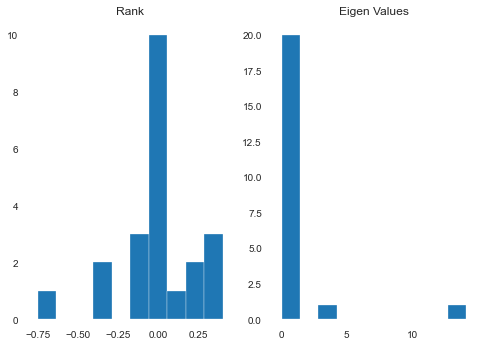

In [14]:
eig_vals, eig_vecs = np.linalg.eig(channels_corrmat)
ranks = np.real(np.diag(eig_vecs))

# print('Eigenvectors \n%s' %eig_vecs)
print('\nEigenvalues \n%s' % np.real(eig_vals))
sum(np.real(np.diag(eig_vecs)) > 1e-5)
plt.subplot(1,2,1), plt.hist(np.real(np.diag(eig_vecs))), plt.title('Rank')
plt.subplot(1,2,2), plt.hist(np.real(eig_vals)), plt.title('Eigen Values')

In [15]:
np.sum(np.array(abs(channels_corrmat)>0.9),0)

array([5, 1, 8, 1, 3, 1, 2, 1, 1, 8, 5, 5, 2, 2, 5, 7, 5, 1, 3, 1, 2, 1])

### Drop Channels

Load 50 tokens files randomly selected from the database

In [16]:
import pickle
if os.path.isfile('tmp/eda.pkl'):
    with open('tmp/eda.pkl', 'rb') as fp:
        dfs = pickle.load(fp)
else:
    dfs = []
    for token in token_paths:
        dfs.append(process(token))
    with open('tmp/eda.pkl', 'wb') as fp:
        pickle.dump(dfs, fp)

Plot the averaged correlation matrix of the 50 tokens.

In [17]:
ch_cor_mats = [df1.corr() for df1 in dfs]

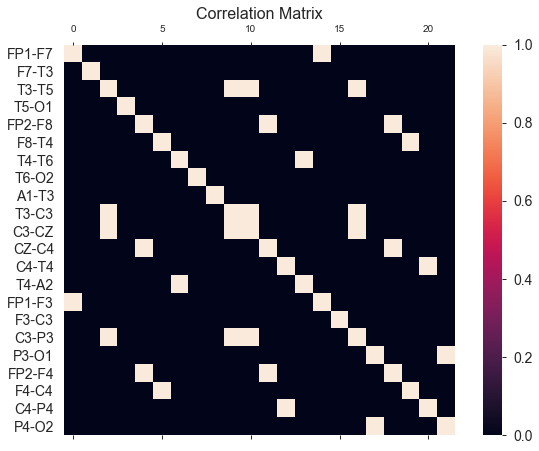

In [18]:
chmatdf = pd.DataFrame(ch_cor_mats[0])
for i in range(1,10):
    chmatdf += pd.DataFrame(ch_cor_mats[i])
plot_corrmat(chmatdf/10>0.5, l)

Channels and their locations on the head.
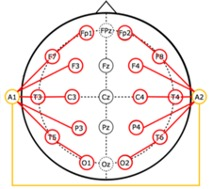

It seems many channels are strongly correlated with each other. For randomly sampled 50 patients. the strongly correlated channels corresponds to line #3 and #4

In [19]:
# Drop channels
dfs = [dfs[i][['ch'+str(i) for i in range(0,8)]] for i in range(0, len(dfs))]

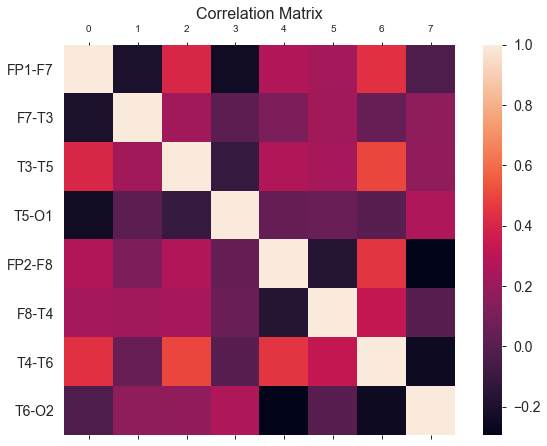

In [20]:
ch_cor_mats = [df1.corr() for df1 in dfs]
# pd.DataFrame([np.sum(np.array(abs(chmat)>0.8),0) for chmat in ch_cor_mats], columns=l)
chmatdf = pd.DataFrame(ch_cor_mats[0])
for i in range(1,10):
    chmatdf += pd.DataFrame(ch_cor_mats[i])
plot_corrmat(chmatdf/10, l[0:8])

In [21]:
eig_vals, eig_vecs = np.linalg.eig(chmatdf)
ranks = np.real(np.diag(eig_vecs))
eig_vals, ranks


(array([23.36150628, 15.25455826,  4.71565861,  2.38641842,  3.03375783,
        11.52653114, 10.14298139,  9.57858806]),
 array([ 0.45866848,  0.48278774, -0.54126103, -0.34452388, -0.21737091,
        -0.33937729,  0.05705283,  0.4072627 ]))

In [22]:
def drop_channels(df):
    return df.iloc[:,0:8]

## Resampling to 256 Hz

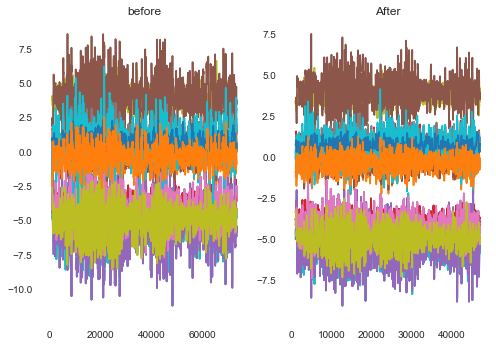

In [39]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2)

f, s, l = read_1_token(os.path.join(train_path, tcp_type, patient_group, patient, session, token))
pd.DataFrame(np.transpose(s)).rolling(1000).mean()\
    .plot(legend=False, title='before', ax=axes[0])

num=int(np.shape(s)[1]*256/np.mean(f))

np.random.seed(10)
s = signal.resample(s, num=num, axis=1)
pd.DataFrame(np.transpose(s)).rolling(1000).mean()\
    .plot(legend=False, title='After', ax=axes[1])